In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# 1. Data Extraction
# Load the raw CSV file
df_orig = pd.read_csv('carprices.csv')
display(df_orig.head())  # Show first few rows
df_copy = df_orig.copy() # Duplicate cos dataset is huge af

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7119256118,https://mohave.craigslist.org/ctd/d/lake-havas...,mohave county,https://mohave.craigslist.org,3495,2012.0,jeep,patriot,like new,4 cylinders,...,NaN,NaN,NaN,silver,https://images.craigslist.org/00B0B_k2AXIJ21ok...,"THIS 2012 JEEP PATRIOT IS A 4CYL. AC, STEREO, ...",NaN,az,34.4554,-114.2690
1,7120880186,https://oregoncoast.craigslist.org/cto/d/warre...,oregon coast,https://oregoncoast.craigslist.org,13750,2014.0,bmw,328i m-sport,good,NaN,...,rwd,NaN,sedan,grey,https://images.craigslist.org/00U0U_3cLk0WGOJ8...,Selling my 2014 BMW 328i with the following be...,NaN,or,46.1837,-123.8240
2,7115048251,https://greenville.craigslist.org/cto/d/sparta...,greenville / upstate,https://greenville.craigslist.org,2300,2001.0,dodge,caravan,excellent,6 cylinders,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_t4WqYn5nDC...,"01 DODGE CARAVAN,3.3 ENGINE,AUT TRANS,199000 M...",NaN,sc,34.9352,-81.9654
3,7119250502,https://mohave.craigslist.org/cto/d/lake-havas...,mohave county,https://mohave.craigslist.org,9000,2004.0,chevrolet,colorado ls,excellent,5 cylinders,...,rwd,mid-size,pickup,red,https://images.craigslist.org/00J0J_lJEzfeVLHI...,"2004 Chevy Colorado LS, ONLY 54000 ORIGINAL MI...",NaN,az,34.4783,-114.2710
4,7120433904,https://maine.craigslist.org/ctd/d/searsport-t...,maine,https://maine.craigslist.org,0,2021.0,NaN,Honda-Nissan-Kia-Ford-Hyundai-VW,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/01010_j0IW34mCsm...,CALL: 207.548.6500 TEXT: 207.407.5598 **WE FI...,NaN,me,44.4699,-68.8963


In [45]:
print(df_copy[df_copy['price'] > 1000000])  # Outliers?

                id                                                url  \
10392   7117325706  https://memphis.craigslist.org/cto/d/eads-cash...   
11651   7116671058  https://treasure.craigslist.org/ctd/d/we-the-m...   
20340   7117232166  https://jacksontn.craigslist.org/cto/d/eads-ca...   
23295   7112315518  https://utica.craigslist.org/ctd/d/syracuse-we...   
33833   7118528004  https://wyoming.craigslist.org/cto/d/cheyenne-...   
...            ...                                                ...   
402109  7119105480  https://kansascity.craigslist.org/cto/d/bonner...   
407508  7114330140  https://poconos.craigslist.org/cto/d/bushkill-...   
415576  7119734753  https://sarasota.craigslist.org/ctd/d/sarasota...   
416852  7118412427  https://bgky.craigslist.org/cto/d/alvaton-corv...   
427213  7120997478  https://phoenix.craigslist.org/evl/ctd/d/scott...   

                    region                         region_url       price  \
10392              memphis     https://memphis

this dataset cursed

In [4]:
# Filter extreme outliers
# Set max values to just 100K, see documents below
df_copy = df_copy[df_copy['price'] <= 100000]

# Also remove price below 500, that's just wrong
df_copy = df_copy[df_copy['price'] > 500]

print(df_copy['price'].describe())

count    395602.000000
mean      14089.760780
std       11082.034603
min         502.000000
25%        5995.000000
50%       11000.000000
75%       18977.000000
max      100000.000000
Name: price, dtype: float64


In [73]:
#Check
print(df_orig['price'].max())
print(df_orig['price'].min())
print(df_copy['price'].max())
print(df_copy['price'].min())

3647256576
0
100000
502


In [6]:
# Extract relevant columns
df = df_copy.copy()
columns = ['year', 'manufacturer', 'odometer', 'fuel', 'transmission', 'state', 'price']
df = df[columns]

# Drop entries with empty prices
df = df[df['price'] > 0].dropna(subset=['price'])

# Fill missing values
df['odometer'] = df['odometer'].fillna(0)
df[['manufacturer', 'fuel', 'transmission', 'state']] = df[['manufacturer', 'fuel', 'transmission', 'state']].fillna('Unknown')

for column in df.columns:
    print(f"Unique values in '{column}': {df[column].unique()}\n")

Unique values in 'year': [2012. 2014. 2001. 2004. 2005. 2017. 2016. 2006. 2009. 2011. 2010. 2018.
 1999. 2019. 1998. 2015. 2007. 2000. 1988. 2013. 1965. 1997. 2002. 1976.
 1996. 1980. 1944. 2008. 2020. 2003. 1978. 1940. 1952. 1989.   nan 1986.
 1991. 1995. 1967. 1993. 1966. 1974. 1987. 1957. 1994. 1970. 1981. 1979.
 1960. 1975. 1990. 1977. 1984. 1956. 1982. 1985. 1992. 1983. 1973. 1963.
 1972. 1968. 1931. 1958. 1961. 1962. 1964. 1938. 1949. 1942. 1955. 1969.
 1939. 1971. 1948. 1950. 1919. 1953. 1951. 1941. 1937. 1947. 1930. 1927.
 1959. 1946. 1934. 1933. 1929. 1936. 1923. 1925. 1932. 1954. 1900. 1928.
 1935. 2021. 1916. 1912. 1911. 1926. 1917. 1922. 1915. 1924. 1945. 1920.]

Unique values in 'manufacturer': ['jeep' 'bmw' 'dodge' 'chevrolet' 'ford' 'honda' 'toyota' 'nissan'
 'subaru' 'gmc' 'volkswagen' 'kia' 'acura' 'ram' 'chrysler' 'hyundai'
 'cadillac' 'volvo' 'mini' 'mercedes-benz' 'Unknown' 'audi' 'mazda'
 'pontiac' 'buick' 'infiniti' 'mitsubishi' 'rover' 'lincoln' 'lexus'
 'fiat' '

In [ ]:
# Extract relevant columns
df = df_copy.copy()
columns = ['year', 'manufacturer', 'odometer', 'fuel', 'transmission', 'state', 'price']
df = df[columns]

# Drop entries with empty prices
df = df[df['price'] > 0].dropna(subset=['price'])

# Fill missing values
df['odometer'] = df['odometer'].fillna(0)
df[['manufacturer', 'fuel', 'transmission', 'state']] = df[['manufacturer', 'fuel', 'transmission', 'state']].fillna('Unknown')

df_nt = df.copy() # Duplicate as non-tokenized, preprocessed dataset copy

# Turn string data into machine readable numerical values
# Non-tokenized values are stored in df_nt
manual_mappings = {
    "manufacturer": {m: i for i, m in enumerate(df['manufacturer'].unique())},
    "fuel": {f: i for i, f in enumerate(df['fuel'].unique())},
    "transmission": {t: i for i, t in enumerate(df['transmission'].unique())},
    "state": {s: i for i, s in enumerate(df['state'].unique())},
}

# Apply mappings
for col, mapping in manual_mappings.items():
    df[col] = df[col].map(mapping)

df = df.dropna()
    
print("df = ", df)
print("non-tokenized df = ", df_nt) # Preservation lang for maybe later use

NameError: name 'df_copy' is not defined

# LogReg

In [ ]:
# 3. Model Creation & Training
# Features [X] and target [y]
X = df.drop(columns=['price'])  # Features (everything except price)
y = df['price']  # Target variable (price)
# Split dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train Linear Regression model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train)

LinearRegression()

# Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

# 3. Model Creation & Training
# Features [X] and target [y]
X = df.drop(columns=['price'])  # Features (everything except price)
y = df['price']  # Target variable (price)
# Split dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

MAE: 7518.47
RMSE: 11489.64
R² Score: 0.11


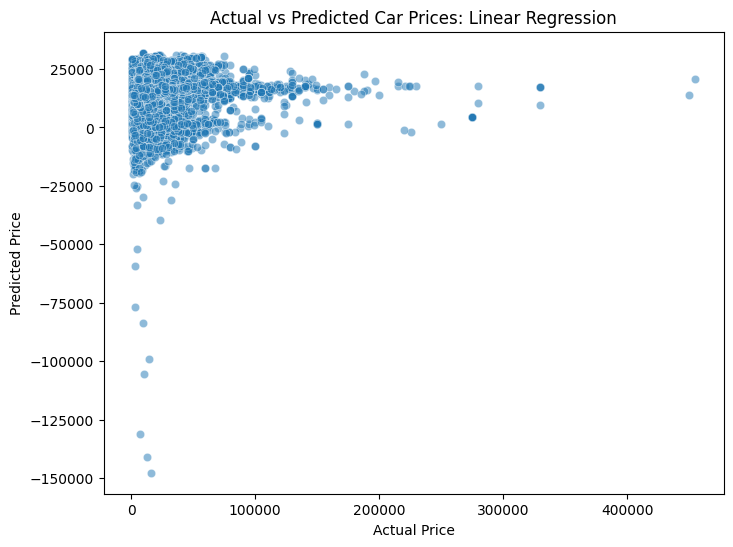

In [62]:
# LogReg Assess
# Predict test set
y_pred = log_reg.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

## Reverse map to revert data tokenization for labelling
# reverse_mappings = {col: {v: k for k, v in manual_mappings[col].items()} for col in manual_mappings}

# X_test_decoded = X_test.copy()
# for col, mapping in reverse_mappings.items():
#     if col in X_test_decoded.columns:
#         X_test_decoded[col] = X_test_decoded[col].map(mapping)

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices: Linear Regression")
plt.show()

MAE: 3340.06
RMSE: 5870.03
R² Score: 0.72


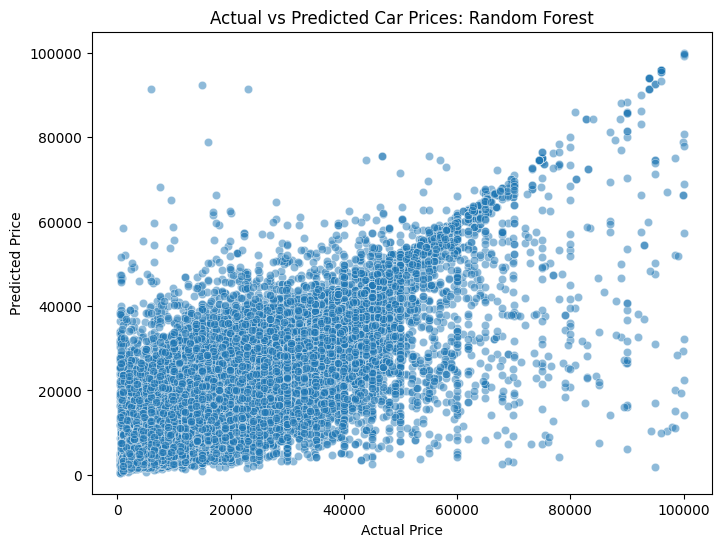

In [76]:
# RF Assess
# Predict test set
y_pred = rf.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

## Reverse map to revert data tokenization for labelling
# reverse_mappings = {col: {v: k for k, v in manual_mappings[col].items()} for col in manual_mappings}

# X_test_decoded = X_test.copy()
# for col, mapping in reverse_mappings.items():
#     if col in X_test_decoded.columns:
#         X_test_decoded[col] = X_test_decoded[col].map(mapping)

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices: Random Forest")
plt.show()

# RF looks better

In [77]:
model = rf

This is how the prediction at max price value < 500K.<br/>
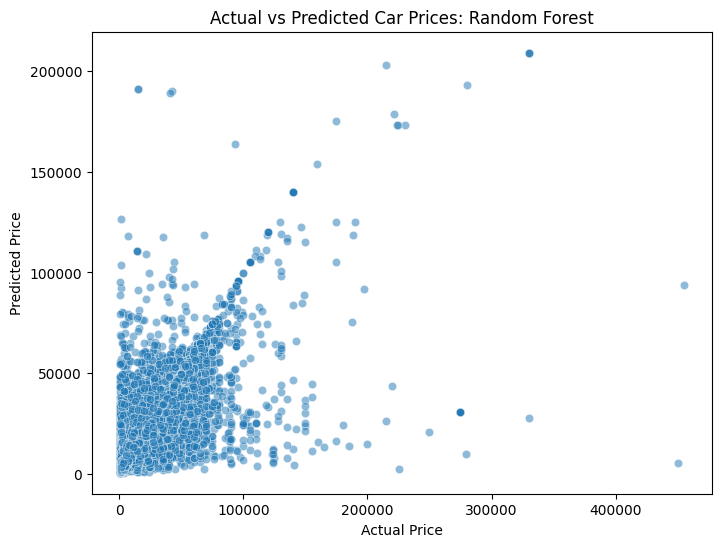<br/>
I have adjusted price range to now be at < 100K.

In [ ]:
# 5. Model Prediction
# Example input for prediction
sample_input = X_test.iloc[0:1]
predicted_price = model.predict(sample_input)[0]
print(f"Predicted Price for Sample Input: ${predicted_price:,.2f}")

# Save the trained model
joblib.dump(model, "randomforest.pkl")

Predicted Price for Sample Input: $28,306.52


['car_price_model.pkl']

In [3]:
import joblib
model = joblib.load("models/logreg.pkl")
print(model)

LinearRegression()
